Similarity matrix s(i,k), reflects how suitable data point k is to serve as an exemplar for data point i.
Responsibilty matirx a(i,k), indicates the accumulated evidence for choosing k as the exemplar of point i, taking into account other candidate exemplars. It is a message sent from i to k.
Availabilty matirx a(i,k), indicates the accumulated evidence of how appropriate is for point i to pick k as its exemplar, given the support from other points that k is an exemplar

for any data point i, the point k that maximizes r(i,k)+a(i,k) either represents that point k is an exemplar if k=i or point k is the exemplar of point i

https://github.com/GGiecold/Concurrent_AP/blob/master/Concurrent_AP.py
https://github.com/ritchie46/vanilla-machine-learning/blob/master/clustering/affinity_propagation.ipynb
https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#affinity-propagation

In [1]:
from abc import ABCMeta, abstractmethod
from contextlib import closing
from ctypes import c_double, c_int

In [2]:
import gc
import multiprocessing

In [3]:
import optparse
import psutil
import time
import warnings

In [4]:
# all the imports needed for this blog
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import imageio
from io import BytesIO
%matplotlib inline
import numba
from numba import jit

In [5]:
import sklearn.cluster as cluster
import seaborn as sns
from sklearn import datasets

sns.set_context('poster')
sns.set_color_codes()

In [6]:
# just to check the memory situation on machine 
def memory():
    """Determine memory specifications of the machine.
    Returns
    -------
    mem_info : dictonary
        Holds the current values for the total, free and used memory of the system.
    """

    mem_info = dict()

    for k, v in psutil.virtual_memory()._asdict().items():
           mem_info[k] = int(v)
           
    return mem_info
mem_free = memory()
mem_free

{'total': 17058295808,
 'available': 6710870016,
 'percent': 60,
 'used': 10347425792,
 'free': 6710870016}

## Data 

In [52]:
# functions for load or save a dictionary
import pickle
def save_obj(obj, obj_name):
    with open('.'+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(obj_name):
    with open('.'+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

In [7]:
def make_fake_2d_data(N_data_E_category=[20,20,20,20,20],Scnd_d=2,Visualization=True):
    
    """ 
    a function for creating fake data to check the performance of the affinity propagation algorithm
    User can adjust the number of categories along with the number of data in each one \
    (to chaeck the performance of algorithm for imbalanced data)
    #Scnd_d=2  number of features of the data (for the purpose of visualization,the default is 2)
    """
    np.random.seed(3)
    for i,N in enumerate(N_data_E_category):        
        size = (N, Scnd_d)
        
        if i==0:
            Data_i = np.random.normal(0, 1, size)
            Data=Data_i
        else:
            center = np.random.rand(2) * 10
            Data_i=np.random.normal(center, .5, size)
            Data=np.r_[Data,Data_i]
    
    
    N_category=len(N_data_E_category)  
    if (N_category<8 and Scnd_d==2 and Visualization==True):
        
        color_list=list('bgrcmyk')[:N_category]
        c = [c for s in [v * N for v,N in zip(color_list,N_data_E_category)] for c in list(s)]
        plt.figure(figsize=(15, 6))
        plt.title('Some clusters in 2d space')
        plt.scatter(Data[:, 0], Data[:, 1], c=c)
        plt.show()
    return Data

#### Data Visulaization Functions

In [8]:
def plot_2d_data(Data_X):
    plt.figure(figsize=(15, 6))        
    plt.scatter(Data_X[:, 0], Data_X[:, 1])
    plt.show()
    
    

#### Selecting Dataset from the available ones

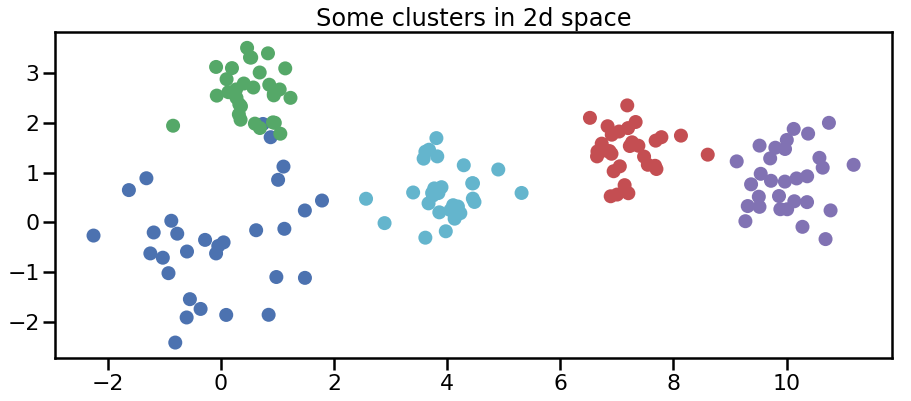

In [9]:
Interested_Dataset=['fake_data','iris_data','Environmental_data'][0]
if Interested_Dataset=='fake_data':
    N_data_E_category_balanced_imbalanced=[[30,30,30,30,30],[15,20,40,20,50]][0]
    Data_Input=make_fake_2d_data(N_data_E_category=N_data_E_category_balanced_imbalanced)
elif Interested_Dataset=='iris_data':    
    iris = datasets.load_iris()
    Data_Input = iris.data
    plot_2d_data(Data_Input)
elif Interested_Dataset=='Environmental_data':
     
    BCF_Elevation=np.load("BCF_Elevation.npy")
    Data_Input =BCF_Elevation[ np.random.choice(np.arange(BCF_Elevation.shape[0]),1000),:]
    plot_2d_data(Data_Input)
else:
    print("the Interested dataset is not available")



### Compute the clustering via Skit-Learn algorithms

In [10]:


plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def Sklearn_clusters(data, algorithm, args, kwds):
    """ a function for performing clustering with Skit-Learn library"""
    
    start_time = time.time()
    #######
    #labels = algorithm(*args, **kwds).fit_predict(data)
    model=algorithm(*args, **kwds).fit(data)
    labels=model.labels_
    if algorithm==cluster.AffinityPropagation:
        cluster_centers_indices=model.cluster_centers_indices_
        cluster_centers=model.cluster_centers_
    ####
    end_time = time.time()
    
    
    plot_clusters(data,gapless_labels=labels)
   
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if algorithm==cluster.AffinityPropagation:
        return labels,cluster_centers_indices,cluster_centers
    else:
        return labels
    

    #plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    

### functions 

In [11]:
cache_=False
nopython_=True

In [12]:
%load_ext cython

In [13]:
def Similarity(x,y):
    """computes the similarity, negative eulidian distance, between two vecotrs"""
    return -np.sum((x-y)**2)


In [14]:

#@jit(nopython=nopython_, cache=cache_)
def Initialize_Matrices(X_data,Similarity_metric='Euclidean',memory_efficinet=True):
    """create the similarity (S), availability (A) and Responsibility (R) matrices given input data
    X_data >> rows represent observations and columns represent features """
    n=X_data.shape[0]
    S=np.zeros((n,n))
    A=np.zeros((n,n))
    R=np.zeros((n,n))
    if Similarity_metric=='Euclidean':
        if memory_efficinet==False:
            for i in range(n-1):
                for j in range(i+1,n):
                        S[i,j]=Similarity(X_data[i,:],X_data[j,:]) 
            S=S+S.T
            
        else:
            S=-1*pairwise_dists(X_data, X_data)
        return S,R,A
    else:
        raise ValueError("The only Predefined Similarity metric is 'Euclidean'.\
 For '%s' metric, a new function should be defined"%Similarity_metric)

In [15]:
#@jit(nopython=nopython_, cache=cache_)
def pairwise_dists(x, y):
    """ Computing pairwise distances using memory-efficient
        vectorization.

        Parameters
        ----------
        x : numpy.ndarray, shape=(M, D)
        y : numpy.ndarray, shape=(N, D)

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            The square Euclidean distance between each pair of
            rows between `x` and `y`."""
    return  np.sum(x**2,axis=-1).reshape(-1,1)+np.sum(y**2,axis=-1)-2*np.dot(x,y.T) 

In [16]:
def Update_R_loop(S,R,A,damping_factor=0.5):
    n=S.shape[0]
    for i in range(n):
        for k in range(n):
            # approach 1
    #         Ids_kp=[kp for kp in list(range(n)) if not kp==k and not kp==i]
    #         temp=np.max(A[i,Ids_kp]+S[i,Ids_kp])
            #approach 2
            temp1=(A[i,:]+S[i,:])
            temp1[i]=-np.inf
            temp1[k]=-np.inf
            temp=np.max(temp1)

            R[i,k]=R[i,k]*damping_factor+(S[i,k]-temp)*(1-damping_factor)
    return R

In [17]:
#@jit(nopython=nopython_, cache=cache_)
def Update_R_Broadcast(S,R,A,temp=None,damping_factor=0.5):
    if temp is None: temp=np.zeros_like(R)
    temp=A+S
    temp.flat[::(temp.shape[0]+1)]=-np.inf #np.fill_diagonal(temp,-np.inf) 
    rows=np.arange(S.shape[0])
    Id_max_E_row=np.argmax(temp,axis=1)
    first_max=temp[rows,Id_max_E_row]
    temp[rows,Id_max_E_row]=-np.inf
    second_max=temp[rows,np.argmax(temp,axis=1)]
    Max_mat_A_plus_S=np.zeros_like(S)+first_max.reshape(-1,1)#[:,None]
    Max_mat_A_plus_S[rows,Id_max_E_row]=second_max
    R=R*damping_factor+(S-Max_mat_A_plus_S)*(1-damping_factor)
    return R

In [18]:
def Update_A_loop(R,A,damping_factor=0.5):
    n=R.shape[0]
    for i in range(n):
        for k in range(n):
            
            temp1=np.array(R[:, k]) #R[:,k]+0.0 
            temp1[i]=-np.inf
            temp1[k]=-np.inf

            temp_sum=np.sum(temp1[temp1>0])
            
            if i!=k:
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*min(0, R[k,k]+temp_sum)
            else:            
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*temp_sum
    return A

In [19]:
#@jit(nopython=nopython_, cache=cache_)
def Update_A_Broadcast(R,A,temp=None,damping_factor=0.5):
    
    if temp is None: temp=np.zeros_like(R)
    Approach_paper=True
    if Approach_paper==False:
        a=np.array(R)
        a=np.where(a<0,0,a)# np.clip(a,0,np.inf) # a[a<0]=0 # np.maximum(R, 0, a)
        np.fill_diagonal(a,0)
        temp2=np.sum(a,axis=0)
        a=temp2-np.clip(R,0,np.inf) #np.sum(a,axis=0)-np.clip(a,0,np.inf)
        a=a+np.diag(R)
        a[a>0]=0 # np.clip(a,-np.inf,0)

        np.fill_diagonal(a,temp2)
    else:
        np.maximum(R, 0, temp)        
        temp.flat[::(temp.shape[0]+1)]=np.diag(R) #np.fill_diagonal(temp,np.diag(R)) #temp.flat[::(temp.shape[0]+1)]=np.diag(R)
        temp=np.sum(temp,axis=0)-temp
        temp2=np.diag(temp)
        temp[temp>0]=0 # np.clip(a,-np.inf,0)
        temp.flat[::(temp.shape[0]+1)]=temp2 #np.fill_diagonal(temp,temp2)#temp.flat[::(temp.shape[0]+1)]=temp2
        
    A=damping_factor*A+(1-damping_factor)*temp
    
    
    return A

In [20]:
# make sure that both approaches of updating R match

S,R,A=Initialize_Matrices(Data_Input)
R_loop=Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
R_Broadcast=Update_R_Broadcast(S,R,A)

np.testing.assert_allclose(R_Broadcast,R_loop) #np.allclose(R_Broadcast,R_loop)

In [21]:
# check speed R update
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_Broadcast(S,R,A)

118 ms ± 4.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
164 µs ± 23.8 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [22]:
# make sure that both approaches of updating A match
S,R,A=Initialize_Matrices(Data_Input)
A_b=Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
A=Update_A_loop(R,A)
np.testing.assert_allclose(A,A_b)# np.allclose(A,A_b)

In [23]:
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_loop(R,A)

129 µs ± 15.5 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
154 ms ± 5.17 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Cluster Visualization function



In [24]:
def plot_clusters(data,gapless_labels):
    fig = plt.figure(figsize=(15, 5))
    palette = sns.color_palette(palette='deep', n_colors=np.unique(gapless_labels).max() + 1)
    colors = [palette[x] for x in gapless_labels] #[palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.show()

In [25]:
def plot_iteration(iter_i,labels,exemplars,Data,Draw_lines=False):
    """ Here we assume that we are working with 2d data for the purpose of visualization"""
    fig = plt.figure(figsize=(15, 5))
    
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = Data[i][0]
        Y = Data[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            if Draw_lines==True:
                plt.plot([X, Data[exemplar][0]], [Y, Data[exemplar][1]], c=colors[exemplar])
            else:
                plt.plot([Data[exemplar][0]], [Data[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %d @ iteration: %d' % (len(exemplars),iter_i))
    return fig

### main function

In [26]:
def affinity_propagation(Data_X_samples, Similarity_metric_='Euclidean',preference=None, max_iter=200,max_err=1e-4,
                         damping=0.5, copy=True, verbose=False,
                         return_n_iter=False,Visulization_track=False,Plot_Clusters=True,Draw_lines=False):
    """
    
    """
    
    Data_X=np.copy(Data_X_samples)
    n_samples=Data_X.shape[0]
    S,R,A=Initialize_Matrices(Data_X,Similarity_metric_)
    

    if preference is None:
        preference = np.median(S)
    if damping < 0.5 or damping >= 1:
        raise ValueError('Based on the suggestion of authors (Brendan J. Frey* and Delbert Dueck 2007) ,\
        damping must be >= 0.5 and < 1')

    preference = np.array(preference)
    S.flat[::(n_samples + 1)] = preference #np.fill_diagonal(S,preference)  #  S.flat[::(n_samples + 1)] = preference
    
    # Intermediate results
    current_sol=np.zeros_like(S)
    temp_arr=np.zeros_like(S)
    
    
    last_sol=np.zeros_like(S)
    current_sol=np.zeros_like(S)
    last_exemplars = np.array([])
    
    # Remove degeneracies
    random_state = np.random.RandomState(0)
    S += ((np.finfo(np.double).eps * S + np.finfo(np.double).tiny * 100) *
          random_state.randn(n_samples, n_samples))
    
    figures=[]
        
    for it in range(max_iter):

        R=Update_R_Broadcast(S,R,A,temp_arr,damping)
        A=Update_A_Broadcast(R,A,temp_arr,damping)
        
        current_sol=A+R
        labels = np.argmax(current_sol, axis=1)
        exemplars = np.unique(labels)
        
        if Visulization_track==True:
            if (np.all(last_exemplars != exemplars)):
                figures.append(plot_iteration(it,labels,exemplars,Data_X,Draw_lines=Draw_lines))
        
        if np.allclose(last_sol, current_sol):#np.sqrt(np.sum((last_sol- current_sol)**2)) < max_err:# np.allclose(last_sol, current_sol):
            print(exemplars, it)
            break

        last_sol = current_sol
        last_exemplars = exemplars
    # mapping the labels into a sorted, gapless, list    
    #labels = np.searchsorted(last_exemplars, labels)
    
    Cluster_Centers=Data_X[last_exemplars]
    
    if Plot_Clusters==True:
        plot_clusters(Data_X,gapless_labels=np.searchsorted(last_exemplars, labels))
        #plot_iteration(it,labels,last_exemplars,Data_X,Draw_lines)
    
    if Visulization_track==True:
        return last_exemplars,labels,Cluster_Centers,it,figures
    else:
        return last_exemplars,labels,Cluster_Centers,it
    

In [27]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=False)

[  3  25  51  62 107 138] 69
Wall time: 39.7 ms


[  3  25  51  62 107 138] 69


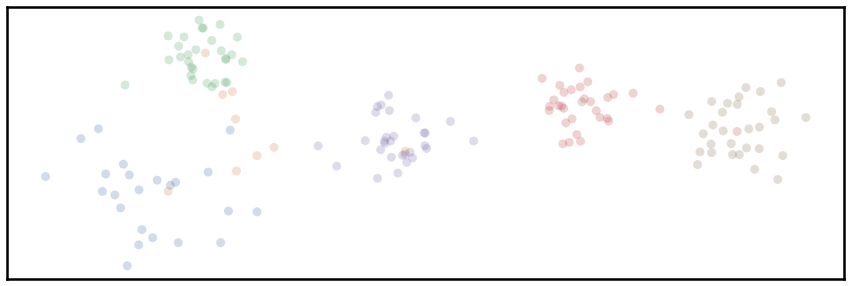

Wall time: 95.7 ms


In [28]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=True)

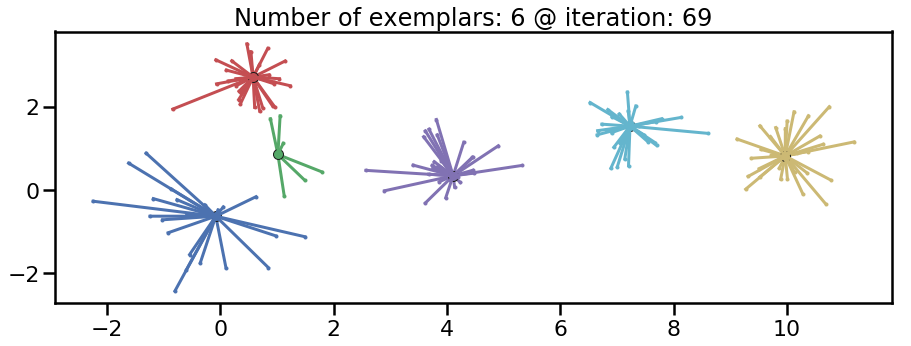

In [29]:
fig= plot_iteration(last_iteration,labels,exemplars,Data_Input,Draw_lines=True)

### Compareing with Skit-Learn

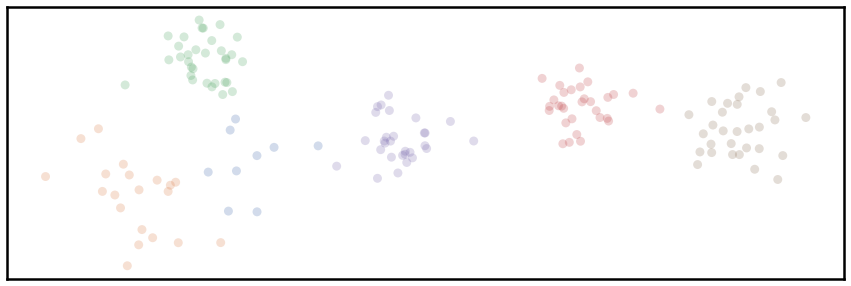

Clustering took 0.07 s
Wall time: 126 ms


In [30]:
%%time
args=()
kwds={'damping':0.5,'convergence_iter':400}
labels_SK,cluster_centers_indices_SK,cluster_centers_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
labels_SK

In [31]:
print("Exemplars found by SKlearn: \n",np.unique(cluster_centers_indices_SK))
print("Exemplars found by Implemented Algorithm: \n",np.unique(labels))

Exemplars found by SKlearn: 
 [ 11  22  51  62  99 138]
Exemplars found by Implemented Algorithm: 
 [  3  25  51  62 107 138]


In [32]:
print("Cluster centers found by SKlearn: \n",cluster_centers_SK)
print("Cluster centers found by Implemented Algorithm: \n",Cluster_Centers)


Cluster centers found by SKlearn: 
 [[ 1.48614836  0.23671627]
 [-0.59664964 -0.58859438]
 [ 0.57541884  2.70899698]
 [ 7.22817703  1.53270549]
 [ 3.9002663   0.70472642]
 [ 9.96820508  0.81722836]]
Cluster centers found by Implemented Algorithm: 
 [[-0.08274148 -0.62700068]
 [ 1.01318344  0.85279784]
 [ 0.57541884  2.70899698]
 [ 7.22817703  1.53270549]
 [ 4.1061428   0.34226963]
 [ 9.96820508  0.81722836]]


In [33]:
from sklearn.metrics import pairwise_distances_argmin
def predict_cluster(Data_points,Cluster_centers):
    """ assigning each data point to a cluster by finding the minimum distance between each point and cluster centers"""
    return pairwise_distances_argmin(Data_points,Cluster_centers)

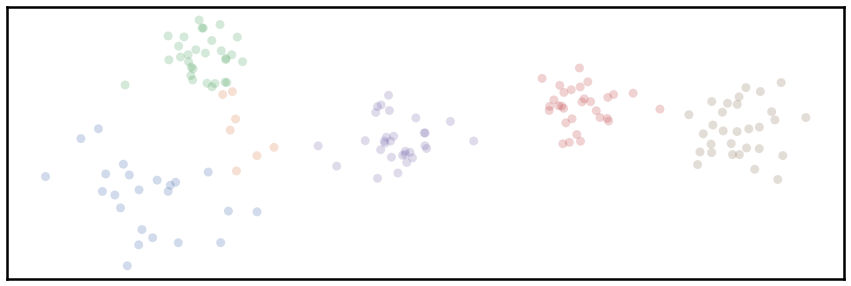

In [34]:
plot_clusters(Data_Input,gapless_labels=predict_cluster(Data_Input,Cluster_Centers) )

### some efforts for speeding up 

In [35]:
from multiprocessing import Pool, Value
from joblib import Parallel
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp

[  3  25  51  62 107 138] 69


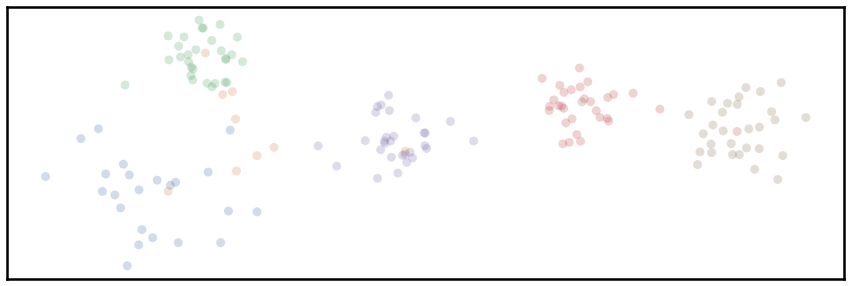

Wall time: 328 ms


In [36]:
%%time

with ProcessPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


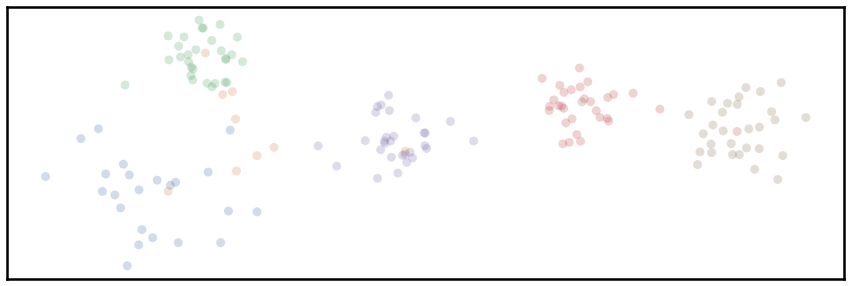

Wall time: 97.7 ms


In [37]:
%%time

with ThreadPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


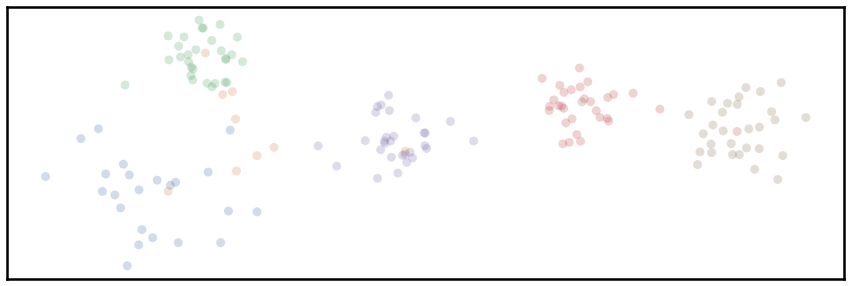

Wall time: 235 ms


In [38]:
%%time
with Pool(processes=4) as pool:
    #pool.apply(affinity_propagation(Data_Input))
    pool.apply_async(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


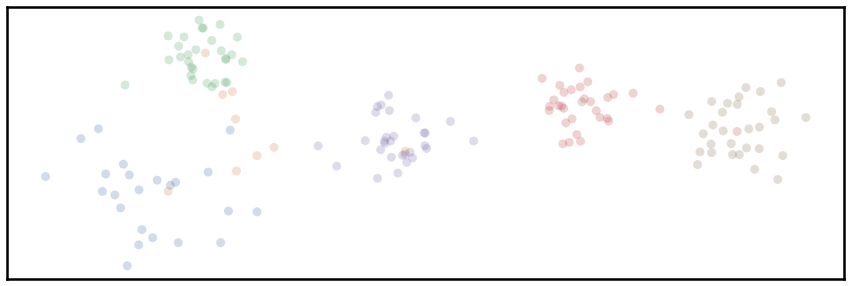

Wall time: 95.7 ms


In [39]:
%%time
_=affinity_propagation(Data_Input)

In [40]:
%prun -q -D affinity_propagation.prof affinity_propagation(Data_Input,Plot_Clusters=False)

[  3  25  51  62 107 138] 69
 
*** Profile stats marshalled to file 'affinity_propagation.prof'. 


In [41]:
# n=200
# A=np.random.randn((n,n))
# b=np.random.randn(n)
# %timeit np.fill_diagonal(A,b)
# %timeit A[::n+1]=b

In [42]:
import pstats
p = pstats.Stats('affinity_propagation.prof')
p.sort_stats('time', 'cumulative').print_stats()
pass

Fri Apr 17 19:30:01 2020    affinity_propagation.prof

         7055 function calls (7049 primitive calls) in 0.047 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       70    0.013    0.000    0.016    0.000 <ipython-input-19-ac169a578390>:2(Update_A_Broadcast)
       70    0.009    0.000    0.014    0.000 <ipython-input-17-03834b81ab85>:2(Update_R_Broadcast)
      210    0.005    0.000    0.005    0.000 {method 'argmax' of 'numpy.ndarray' objects}
       70    0.004    0.000    0.007    0.000 C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:2508(within_tol)
      285    0.002    0.000    0.002    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       70    0.002    0.000    0.010    0.000 C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:2431(isclose)
      140    0.002    0.000    0.002    0.000 {built-in method builtins.a

        1    0.000    0.000    0.000    0.000 C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:1683(<listcomp>)
        1    0.000    0.000    0.000    0.000 {built-in method _thread.get_ident}
        1    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.id}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [44]:
ipyparallel_lib=False
if ipyparallel_lib==True:
    from ipyparallel import Client
    rc = Client()
    rc.ids
    %timeit rc[:].apply_async(affinity_propagation(Data_Input))

## Make a gif of Affinity Propagation Process

In [45]:
def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

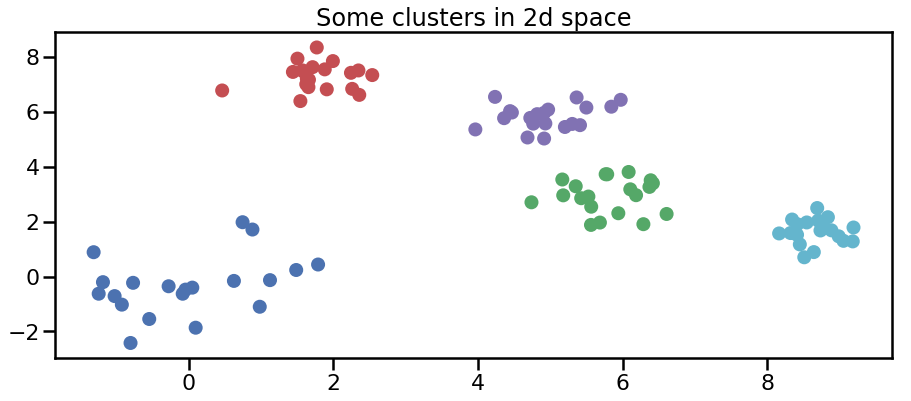

C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[ 7 11 31 53 61 93] 52


In [48]:
_,_,_,_,figures_AF=affinity_propagation(Data_X_samples=make_fake_2d_data(N_data_E_category=[20,20,20,20,20]),\
                                      Plot_Clusters=False,Visulization_track=True,Draw_lines=True)
make_gif(figures_AF, 'Affinity_Propagation.gif', 2)

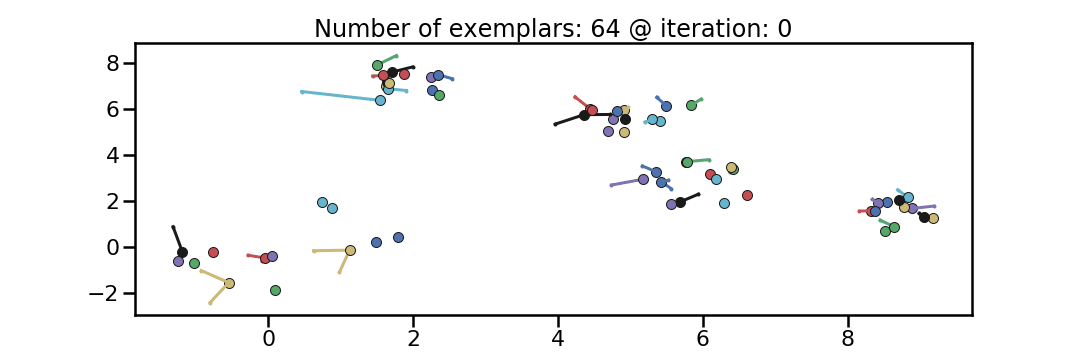

In [49]:
from IPython.display import Image
with open('Affinity_Propagation.gif','rb') as file:
    display(Image(file.read()))

In [50]:
""" Affinity Propagation Clustering of data
    
    Parameters
    ----------
    S : 
        array-like, shape (n_samples, n_samples)
        Matrix of similarities between points
        
    preference : 
        array-like, shape (n_samples,) or float, optional
        Preferences for each point - points with larger values of
        preferences are more likely to be chosen as exemplars. The number of
        exemplars, i.e. of clusters, is influenced by the input preferences
        value. If the preferences are not passed as arguments, they will be
        set to the median of the input similarities (resulting in a moderate
        number of clusters). For a smaller amount of clusters, this can be set
        to the minimum value of the similarities.
        
    max_iter : 
        int, optional, default: 200
        Maximum number of iterations
        
    damping :
        float, optional, default: 0.5
        Damping factor between 0.5 and 1.
        
    Returns
    -------
    cluster_centers_indices : 
        array, shape (n_clusters,)
        index of clusters centers
        
    labels : 
        array, shape (n_samples,)
        cluster labels for each point
        
    n_iter : 
        int
        number of iterations run. Returned only if `return_n_iter` is
        set to True.    
        
    Notes
    -----  
    When the algorithm does not converge, it returns an empty array as
    ``cluster_center_indices`` and ``-1`` as label for each training sample.
        
"""       

' Affinity Propagation Clustering of data\n    \n    Parameters\n    ----------\n    S : \n        array-like, shape (n_samples, n_samples)\n        Matrix of similarities between points\n        \n    preference : \n        array-like, shape (n_samples,) or float, optional\n        Preferences for each point - points with larger values of\n        preferences are more likely to be chosen as exemplars. The number of\n        exemplars, i.e. of clusters, is influenced by the input preferences\n        value. If the preferences are not passed as arguments, they will be\n        set to the median of the input similarities (resulting in a moderate\n        number of clusters). For a smaller amount of clusters, this can be set\n        to the minimum value of the similarities.\n        \n    max_iter : \n        int, optional, default: 200\n        Maximum number of iterations\n        \n    damping :\n        float, optional, default: 0.5\n        Damping factor between 0.5 and 1.\n       

## Comaprison with other clustering algorithm

#### K-Means

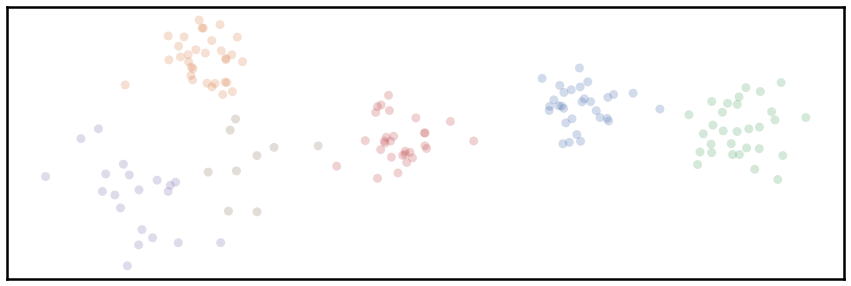

Clustering took 0.02 s


array([5, 4, 4, 4, 4, 4, 1, 4, 4, 5, 4, 5, 4, 5, 4, 1, 4, 4, 4, 5, 4, 4,
       4, 4, 4, 5, 5, 5, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [51]:
labels_SK=Sklearn_clusters(Data_Input, cluster.KMeans, (), {'n_clusters':6})
#labels_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
labels_SK

### Environmental data

In [55]:
Envirnonmental_Data_dic=load_obj('Envirnonmental_Data')
Envirnonmental_Data_dic

{'dem': array([[1588.9183  , 1677.6432  , 1656.2432  , ..., 1611.0812  ,
         1609.4529  , 1607.8513  ],
        [1614.8094  , 1647.1166  , 1567.0974  , ..., 1607.8534  ,
         1606.7502  , 1605.412   ],
        [1571.3574  , 1543.9697  , 1545.6289  , ..., 1604.6162  ,
         1603.6112  , 1602.8593  ],
        ...,
        [ 112.668274,   94.585144,   83.91435 , ..., 2094.5278  ,
         1858.3633  , 1639.9668  ],
        [ 139.00487 ,  113.679   ,   91.71291 , ..., 1768.0704  ,
         1619.9907  , 1559.3394  ],
        [ 171.27051 ,  141.87949 ,  109.29649 , ..., 1536.9166  ,
         1409.3015  , 1334.4492  ]], dtype=float32),
 'ppt': array([[1247.77    , 1261.6675  , 1271.1284  , ...,  126.94334 ,
          127.1075  ,  127.2425  ],
        [1243.56    , 1258.9551  , 1277.145   , ...,  126.895004,
          127.055   ,  127.207504],
        [1228.3867  , 1249.72    , 1273.7289  , ...,  126.88333 ,
          127.06833 ,  127.229996],
        ...,
        [ 190.56    ,  18

In [63]:
#np.random.choice(np.arange(Envirnonmental_Data_dic['lat'].shape[0]),5000)
Envirnonmental_Data_dic['lat'].shape,Envirnonmental_Data_dic['dem'].shape

((200, 300), (200, 300))

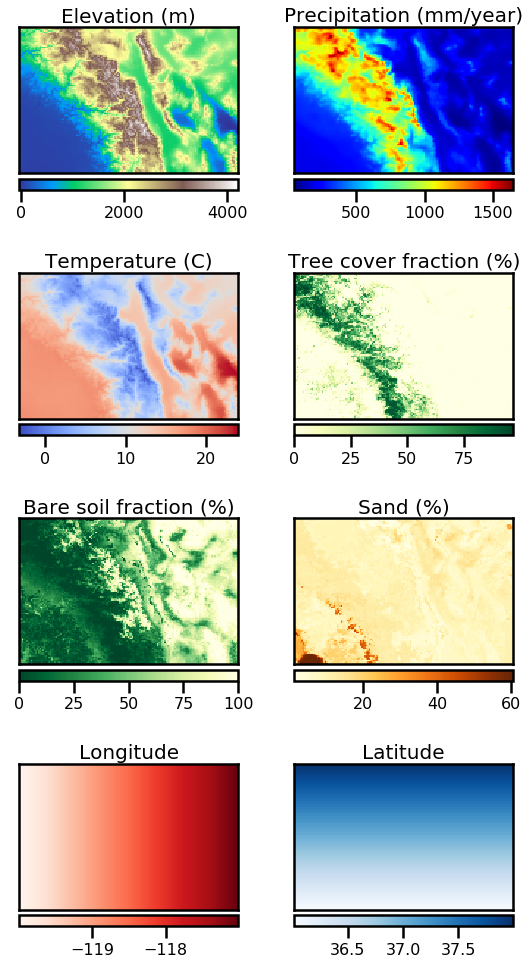

In [65]:
info = {'dem':{'cmap':'terrain','title':'Elevation (m)'},
        'ppt':{'cmap':'jet','title':'Precipitation (mm/year)'},
        'sand':{'cmap':'YlOrBr','title':'Sand (%)'},
        'tcf':{'cmap':'YlGn','title':'Tree cover fraction (%)'},
        'bcf':{'cmap':'YlGn_r','title':'Bare soil fraction (%)'},
        'tmean':{'cmap':'coolwarm','title':'Temperature (C)'},
        'lat':{'cmap':'Blues','title':'Latitude'},
        'lon':{'cmap':'Reds','title':'Longitude'}}
plt.figure(figsize=(8,14))
i = 0
for var in Envirnonmental_Data_dic:
    i += 1
    #print(i)
    plt.subplot(4,2,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Envirnonmental_Data_dic[var][::2,::2],cmap=plt.get_cmap(info[var]['cmap']))
    cb = plt.colorbar(orientation='horizontal',pad=0.03)
    cb.ax.tick_params(labelsize=16)
    plt.title(info[var]['title'],fontsize=20)
plt.tight_layout()
plt.show()

### Focus: Bare cover fraction vs Elevation

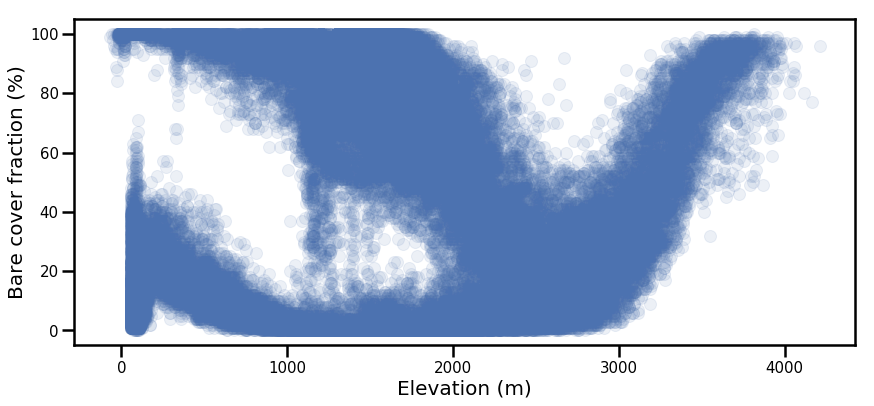

In [61]:
plt.figure(figsize=(14,6))
plt.plot(Envirnonmental_Data_dic['dem'],Envirnonmental_Data_dic['bcf'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

## fit and prediction using K-Means

In [72]:
# We just use a small number of our data to fit the cluster
N_Data_fit=1000
idx = np.random.choice(np.arange(Xn.shape[0]),N_Data_fit)

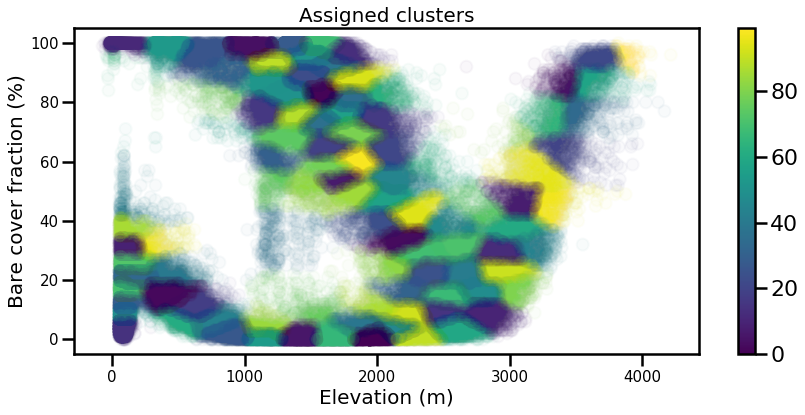

In [73]:
#Bring in the data
v1 = Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size)
v2 = Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size)
#Create data for scikit-learn
X = np.stack((v1,v2)).T
#Normalize the data
Xn = (X - np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))
#Define the number of clusters
k = 100
np.random.seed(1)
model = cluster.KMeans(n_clusters=k)
#Subsample data to fit the model (minimize computation)

Xns = Xn[idx,:]
#Fit the model
model.fit(Xns)
#Predict the clusters on all the data
clusters = model.predict(Xn)
plt.figure(figsize=(14,6))
plt.title('Assigned clusters',fontsize=20)
plt.scatter(Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size),Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size),
            c=clusters,cmap=plt.get_cmap('viridis'),alpha=0.03)
cb = plt.colorbar()
#Ensure the alpha of the colorbar is 1.0
cb.set_alpha(1.0)
cb.draw_all()
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

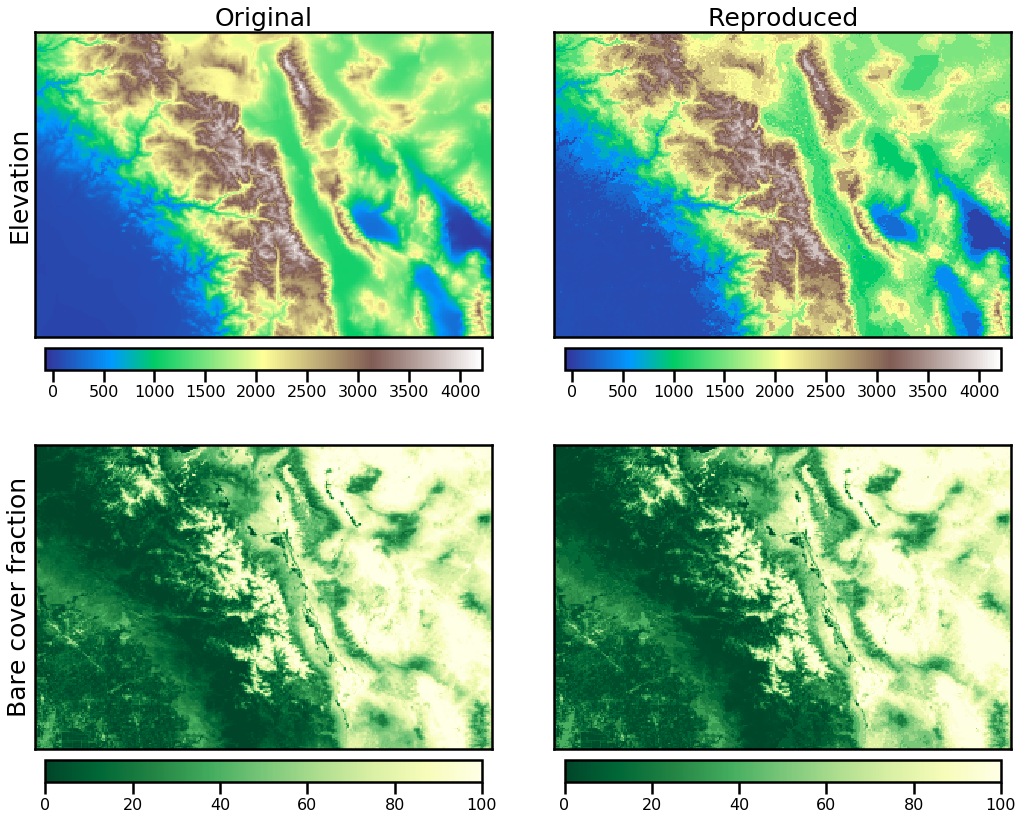

In [71]:
#Assign the cluster centroid values to each cluster
Xpred = np.copy(X)
for i in range(k):
    m = clusters == i
    Xpred[m,:] = np.mean(X[m,:],axis=0)
dem_pred = Xpred[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred = Xpred[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
vmin = np.min(Envirnonmental_Data_dic['dem'])
vmax = np.max(Envirnonmental_Data_dic['dem'])
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

## fit and prediction using developed Affinity Propagation

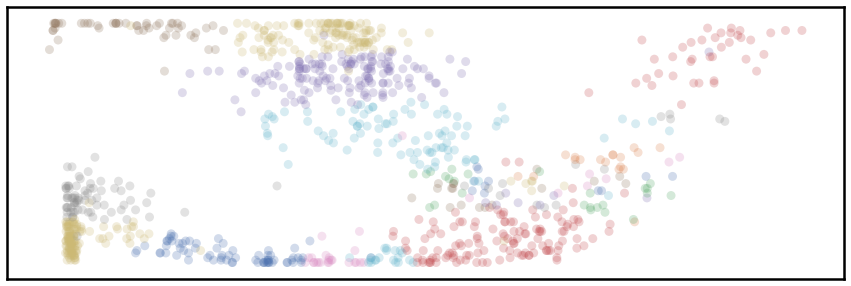

Wall time: 15 s


In [96]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Xns,preference=-1,max_iter=200,Plot_Clusters=True)

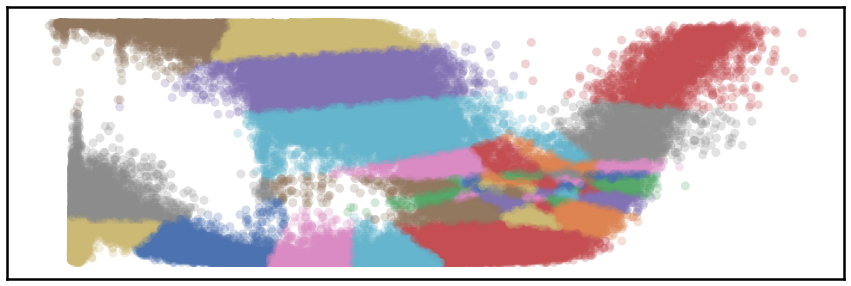

In [97]:
Predicted_labels=predict_cluster(Xn,Cluster_Centers)
plot_clusters(Xn,gapless_labels=Predicted_labels )

C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


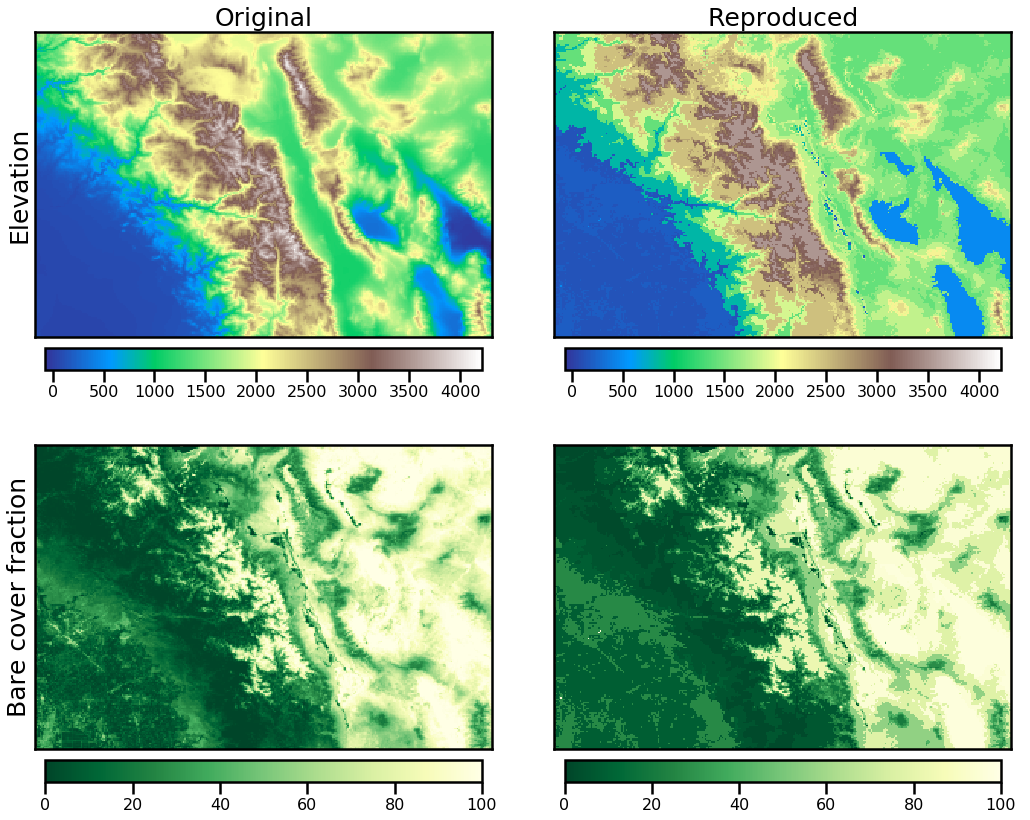

In [98]:
#Assign the cluster centroid values to each cluster
Xpred = np.copy(X)
for i in range(k):
    m =  Predicted_labels == i
    Xpred[m,:] = np.mean(X[m,:],axis=0)
dem_pred = Xpred[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred = Xpred[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
vmin = np.min(Envirnonmental_Data_dic['dem'])
vmax = np.max(Envirnonmental_Data_dic['dem'])
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()